In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import seaborn as sns

In [2]:
def load_roc_data(method_name, save_dir="results/roc"):
    """Load all ROC CSV files for a given method (all folds/classes)."""
    files = glob.glob(f"{save_dir}/{method_name}_*.csv")
    roc_list = []
    for f in files:
        df = pd.read_csv(f)
        roc_list.append((df["fpr"].values, df["tpr"].values))
    return roc_list

In [3]:
def average_roc_curve(roc_list, n_points=100):
    """Compute mean and std of ROC given multiple (fpr, tpr) pairs."""
    if len(roc_list) == 0:
        return None

    mean_fpr = np.linspace(0, 1, n_points)
    tprs = []

    for fpr, tpr in roc_list:
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([auc(fpr, tpr) for fpr, tpr in roc_list])

    return mean_fpr, mean_tpr, std_tpr, mean_auc, std_auc

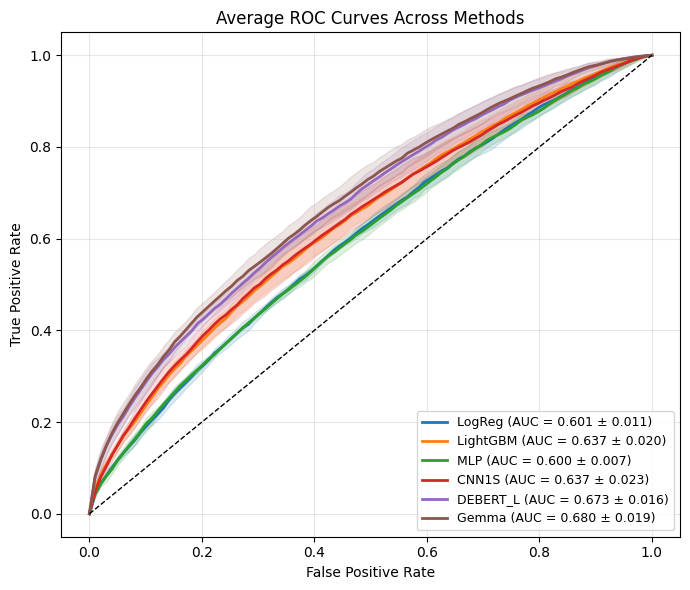

In [4]:
# 1️⃣ Load your ROC CSVs

fixed_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
methods = ["LogReg", "LightGBM", "MLP", "CNN1S", "DEBERT_L", "Gemma"]
method_colors = {method: fixed_palette[i % len(fixed_palette)] for i, method in enumerate(methods)}

roc_data = {
    method: load_roc_data(method, save_dir="/project/egultep_39/jiamin/LLM_battle/results/roc")
    for method in methods
}

# 2️⃣ Then plot all methods
plt.figure(figsize=(7, 6))

for method, curves in roc_data.items():
    if not curves:
        print(f"⚠️ No ROC data found for {method}. Skipping.")
        continue

    avg = average_roc_curve(curves)
    if avg is None:
        continue
    mean_fpr, mean_tpr, std_tpr, mean_auc, std_auc = avg

    plt.plot(
        mean_fpr, mean_tpr, lw=2,
        color=method_colors[method],
        label=f"{method} (AUC = {mean_auc:.3f} ± {std_auc:.3f})"
    )
    plt.fill_between(
        mean_fpr,
        np.maximum(mean_tpr - std_tpr, 0),
        np.minimum(mean_tpr + std_tpr, 1),
        color=method_colors[method],
        alpha=0.15
    )

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curves Across Methods")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("avg_roc_all_methods.png", dpi=300, bbox_inches="tight")
plt.show()